<html><h1><center style="color:blue">Applying Machine Learning Models</center></h1></html>

In [70]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

<html><h1><p style="color:#5dbcd2">Loading Data form File</p></h1></html>

In [71]:
train = pd.read_csv('UCI_HAR_dataset/csv_files/train.csv')
test = pd.read_csv('UCI_HAR_dataset/csv_files/test.csv')
print(train.shape, test.shape)

(7352, 564) (2947, 564)


In [72]:
train.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING


### Making Data for Model

In [73]:
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


<html><h1><p style="color:#44bcd8">Let's start modeling with our Dataset</p></h1></html>

#### Labels that are useful in plotting confusion matrix

In [74]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

In [75]:
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_matrix(cm, title='Confusion matrix', ylabel='True lable', xlabel='Predicted label'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(type(cm))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    return cm

In [76]:
transition_matrix = np.zeros(shape=(6,6))
exten_y_train = train[['subject','ActivityName']]
pre_subject = exten_y_train.iloc[0,0]
pre_pos = labels.index(exten_y_train.iloc[0,1])
for i in range(1, exten_y_train.shape[0]):
    if exten_y_train.iloc[i,0] == pre_subject:
        cur_pos = labels.index(exten_y_train.iloc[i,1])
        transition_matrix[pre_pos, cur_pos] = transition_matrix[pre_pos, cur_pos] + 1
        pre_pos = cur_pos
    else:
        pre_subject = exten_y_train.iloc[i,0]
        pre_pos = labels.index(exten_y_train.iloc[i,1])

print('\n {}'.format(transition_matrix))


 [[1.364e+03 1.000e+00 0.000e+00 4.200e+01 0.000e+00 0.000e+00]
 [4.300e+01 1.243e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 4.200e+01 1.332e+03 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.184e+03 4.200e+01 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 9.300e+02 5.400e+01]
 [0.000e+00 0.000e+00 2.100e+01 0.000e+00 1.400e+01 1.019e+03]]


In [77]:
initial_state_probabilities = transition_matrix.sum(axis=1)[:, np.newaxis]/sum(transition_matrix.sum(axis=1)[:, np.newaxis])
initial_state_probabilities

array([[0.1919247 ],
       [0.17541945],
       [0.18742327],
       [0.16723503],
       [0.13422453],
       [0.14377302]])

<class 'numpy.ndarray'>


array([[9.69438522e-01, 7.10732054e-04, 0.00000000e+00, 2.98507463e-02,
        0.00000000e+00, 0.00000000e+00],
       [3.34370140e-02, 9.66562986e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.05676856e-02, 9.69432314e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.65742251e-01,
        3.42577488e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.45121951e-01, 5.48780488e-02],
       [0.00000000e+00, 0.00000000e+00, 1.99240987e-02, 0.00000000e+00,
        1.32827324e-02, 9.66793169e-01]])

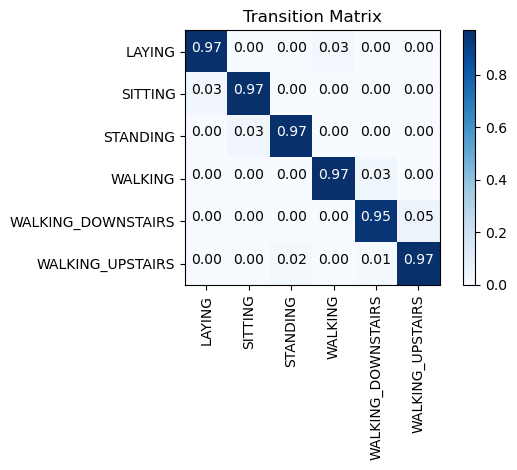

In [78]:
transition_matrix = plot_matrix(transition_matrix, title="Transition Matrix", ylabel='',xlabel='')
transition_matrix

In [79]:
def viterbi_algorithm(transition_matrix, emission_matrix, initial_state_probabilities, observations):
    # Initialize the path probability matrix with zeros
    num_states = len(initial_state_probabilities)
    num_observations = len(observations)
    path_probabilities = [[0] * num_states for _ in range(num_observations)]

    # Initialize the backtracking matrix with zeros
    backtracking = [[0] * num_states for _ in range(num_observations)]

    # Calculate the initial path probabilities
    for state in range(num_states):
        path_probabilities[0][state] = initial_state_probabilities[state] * emission_matrix[state][observations[0]]

    # Calculate the path probabilities for each observation
    for observation_index in range(1, num_observations):
        for state_index in range(num_states):
            max_path_probability = 0
            max_path_state = 0
            for previous_state_index in range(num_states):
                path_probability = path_probabilities[observation_index - 1][previous_state_index]  +\
                                    transition_matrix[previous_state_index][state_index]
                if path_probability > max_path_probability:
                    max_path_probability = path_probability
                    max_path_state = previous_state_index
            path_probabilities[observation_index][state_index] = max_path_probability + \
                                    emission_matrix[state_index][observations[observation_index]]
            backtracking[observation_index][state_index] = max_path_state

    # Backtrack to find the most likely sequence of states
    most_likely_states = [0] * num_observations
    most_likely_states[-1] = max(range(num_states), key=lambda x: path_probabilities[-1][x])
    for observation_index in range(num_observations - 2, -1, -1):
        most_likely_states[observation_index] = backtracking[observation_index + 1][most_likely_states[observation_index + 1]]

    return most_likely_states

In [80]:
from datetime import  datetime
def train_base_model(model):
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    print('==> training time:- {}\n'.format(train_end_time - train_start_time))
    return model

In [81]:
def train_emission_matrix(model):
    y_observe = model.predict(X_train)
    cm = metrics.confusion_matrix(y_train, y_observe)
    return plot_matrix(cm,title="Emission Matrix", ylabel='True label', xlabel='Observe label')

In [82]:
def evaluate_model(y_pred):
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
   
    print('\n ********Confusion Matrix********')
    print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,6))
    # plt.grid(b=False)
    plot_matrix(cm, title='Normalized confusion matrix')
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
    print(classification_report)

In [83]:
def state_to_num(str_states):
    size = len(str_states)
    results = [0] * size
    for i in range(size):
        results[i] = labels.index(str_states[i])
    return results

In [84]:
state_to_num(labels)

[0, 1, 2, 3, 4, 5]

In [85]:
def num_to_state(num_states):
    size = len(num_states)
    results = [''] * size
    for i in range(size):
        results[i] = labels[num_states[i]]
    return results

In [86]:
num_to_state(state_to_num(labels))

['LAYING',
 'SITTING',
 'STANDING',
 'WALKING',
 'WALKING_DOWNSTAIRS',
 'WALKING_UPSTAIRS']

In [87]:
from datetime import datetime
def perform_model(model):
    
    model = train_base_model(model)
    
    # predict test data without hmm
    print('Predicting test data without hmm')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    print('==> testing time without hmm:- {}\n'.format(test_end_time - test_start_time))
    # evaluate base model
    evaluate_model(y_pred)

    # hmm


    emission_matrix = train_emission_matrix(model)
    observations = state_to_num(y_pred)
    numbered_states = viterbi_algorithm(transition_matrix, emission_matrix, initial_state_probabilities, observations)
    str_states = num_to_state(numbered_states)
    evaluate_model(str_states)

    

training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Done....!

==> training time:- 0:00:13.392166

Predicting test data without hmm
Done....!

==> testing time without hmm:- 0:00:00.011997

==> Accuracy:- 0.9579233118425518


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 430  58   0   0   3]
 [  0  16 516   0   0   0]
 [  0   0   0 492   3   1]
 [  0   0   0   4 403  13]
 [  0   0   0  24   2 445]]
<class 'numpy.ndarray'>


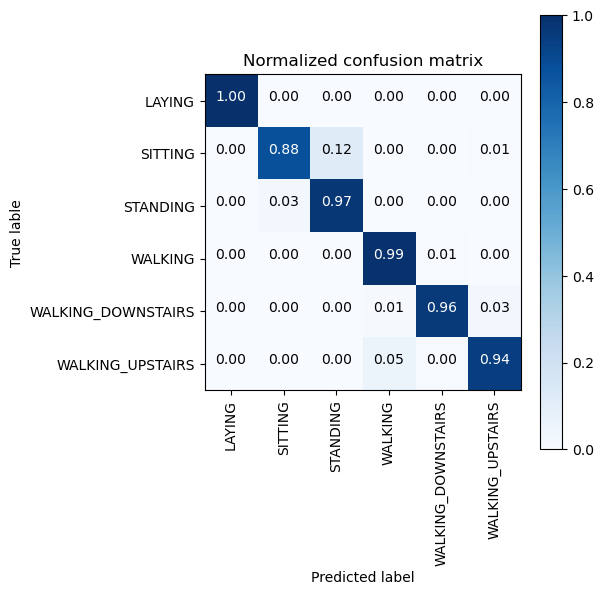

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.97       420
  WALKING_UPSTAIRS       0.96      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

<class 'numpy.ndarray'>
==> Accuracy:- 0.9681031557516118


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 439  49   0   0   3]
 [  0   3 529   0   0   0]
 [  0   0   0 493   3   0]
 [  0   0   0   3 408   9]
 [  0   0   0  23   1 447]]
<class 'numpy.ndarray'>


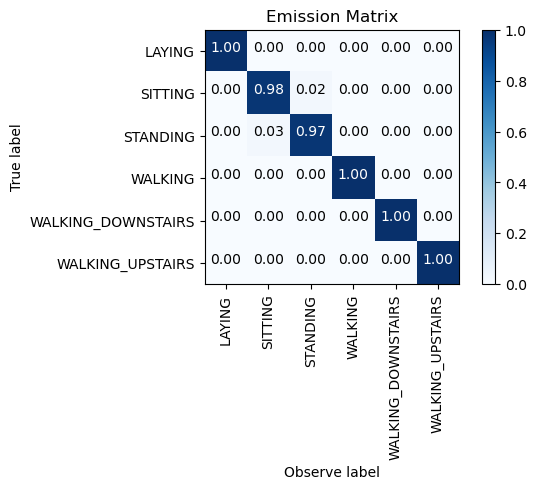

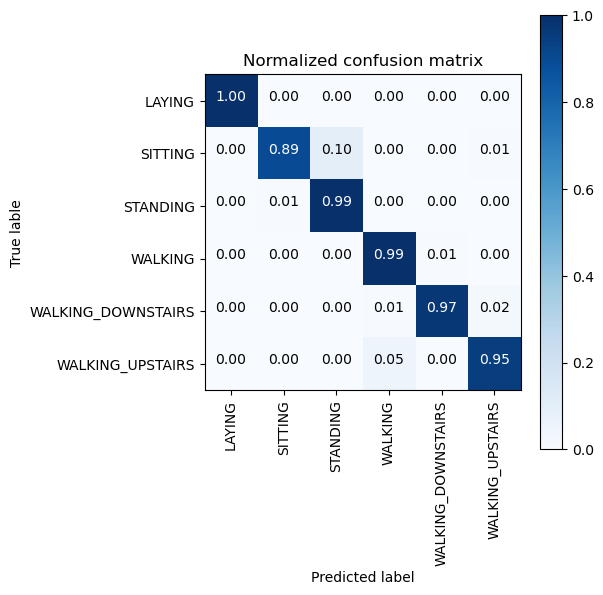

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.99      0.89      0.94       491
          STANDING       0.92      0.99      0.95       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



In [89]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# start Grid search
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
perform_model(log_reg_grid)


training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Done....!

==> training time:- 0:01:04.573529

Predicting test data without hmm
Done....!

==> testing time without hmm:- 0:00:00.013999

==> Accuracy:- 0.9674244994910078


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  2 431  55   0   0   3]
 [  0  10 521   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   3 412   5]
 [  0   0   0  17   0 454]]
<class 'numpy.ndarray'>


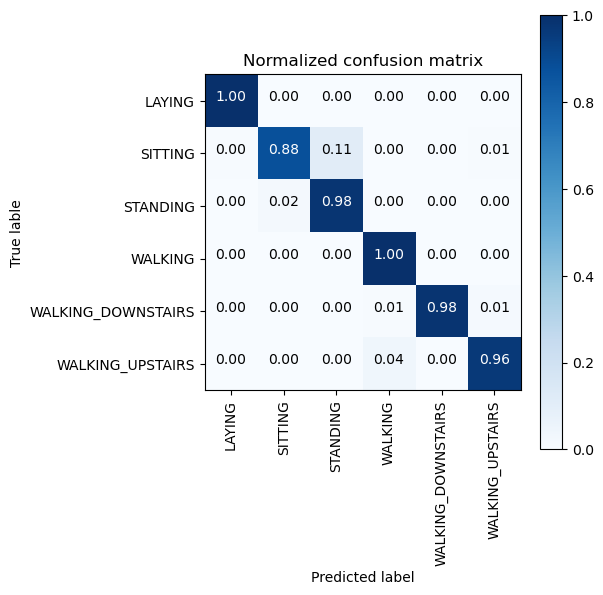

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.88      0.92       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947

<class 'numpy.ndarray'>
==> Accuracy:- 0.9718357651849339


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  2 436  50   0   0   3]
 [  0   5 526   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   3 414   3]
 [  0   0   0  16   0 455]]
<class 'numpy.ndarray'>


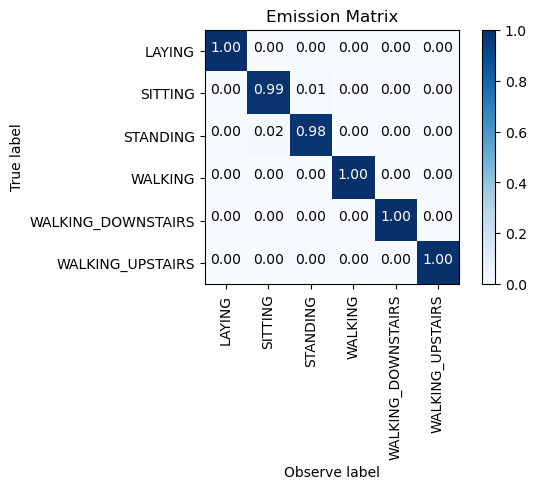

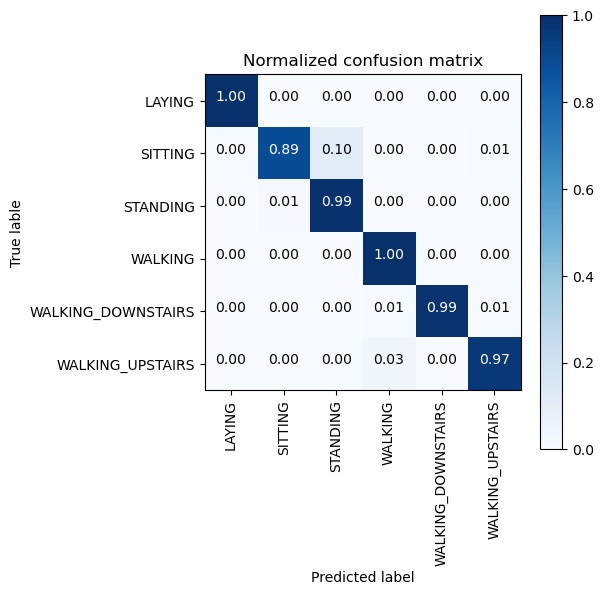

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.99      0.89      0.94       491
          STANDING       0.91      0.99      0.95       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.99      0.99       420
  WALKING_UPSTAIRS       0.99      0.97      0.98       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



In [90]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
perform_model(lr_svc_grid)

training the model..
Done....!

==> training time:- 0:06:44.370644

Predicting test data without hmm
Done....!

==> testing time without hmm:- 0:00:02.194954

==> Accuracy:- 0.9626739056667798


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]
<class 'numpy.ndarray'>


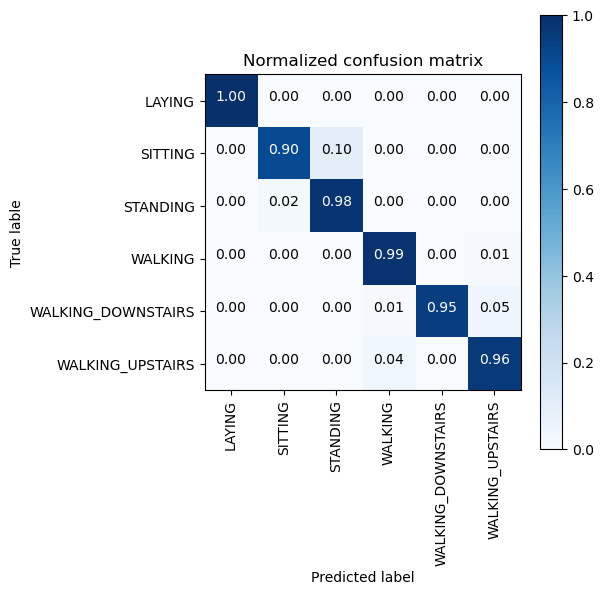

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

<class 'numpy.ndarray'>
==> Accuracy:- 0.9704784526637258


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 448  41   0   0   2]
 [  0   5 527   0   0   0]
 [  0   0   0 491   1   4]
 [  0   0   0   5 397  18]
 [  0   0   0  10   1 460]]
<class 'numpy.ndarray'>


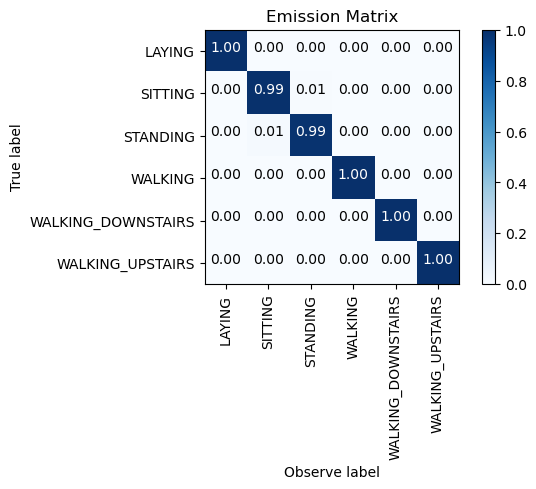

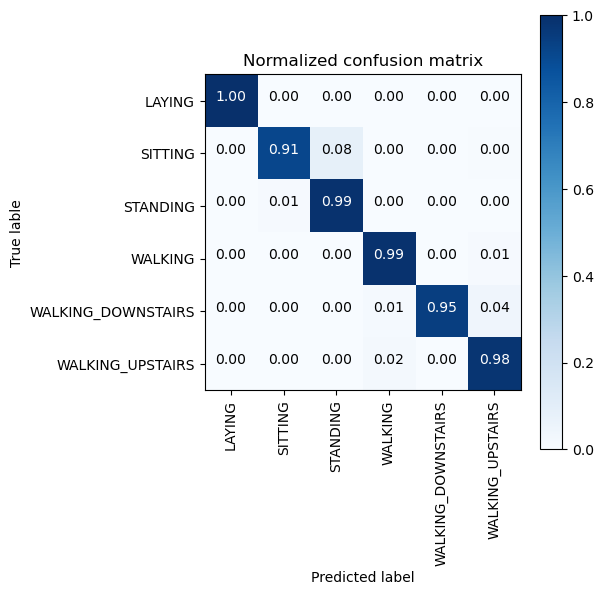

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.99      0.91      0.95       491
          STANDING       0.93      0.99      0.96       532
           WALKING       0.97      0.99      0.98       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.98      0.96       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



In [91]:
parameters = {'C':[2,8,16],'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=-1)
perform_model(rbf_svm_grid)

training the model..
Done....!

==> training time:- 0:00:22.092570

Predicting test data without hmm
Done....!

==> testing time without hmm:- 0:00:00.012561

==> Accuracy:- 0.8659653885307091


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 386 105   0   0   0]
 [  0  93 439   0   0   0]
 [  0   0   0 471  17   8]
 [  0   0   0  13 345  62]
 [  0   0   0  78  19 374]]
<class 'numpy.ndarray'>


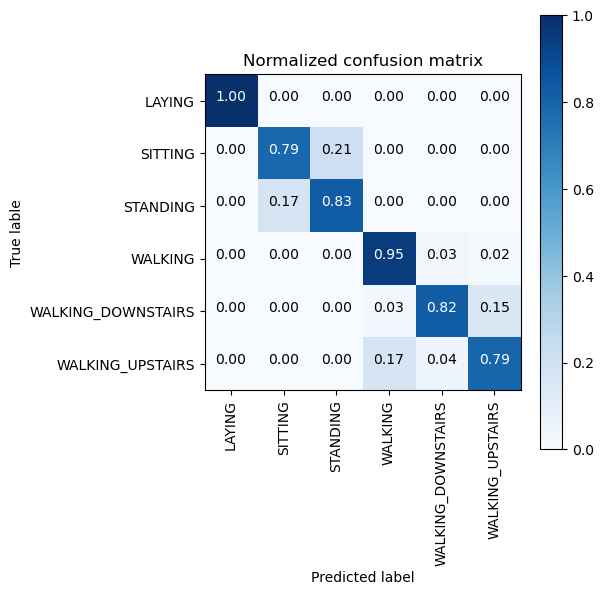

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.81      0.79      0.80       491
          STANDING       0.81      0.83      0.82       532
           WALKING       0.84      0.95      0.89       496
WALKING_DOWNSTAIRS       0.91      0.82      0.86       420
  WALKING_UPSTAIRS       0.84      0.79      0.82       471

          accuracy                           0.87      2947
         macro avg       0.87      0.86      0.86      2947
      weighted avg       0.87      0.87      0.87      2947

<class 'numpy.ndarray'>
==> Accuracy:- 0.8819138106549033


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 381 110   0   0   0]
 [  0  99 433   0   0   0]
 [  0   0   0 492   4   0]
 [  0   0   0  13 354  53]
 [  0   0   0  55  14 402]]
<class 'numpy.ndarray'>


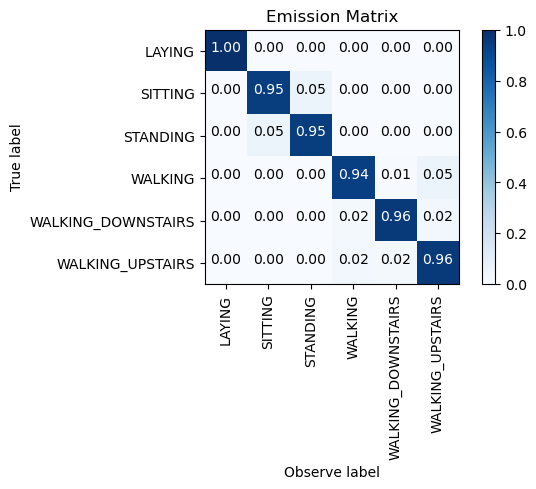

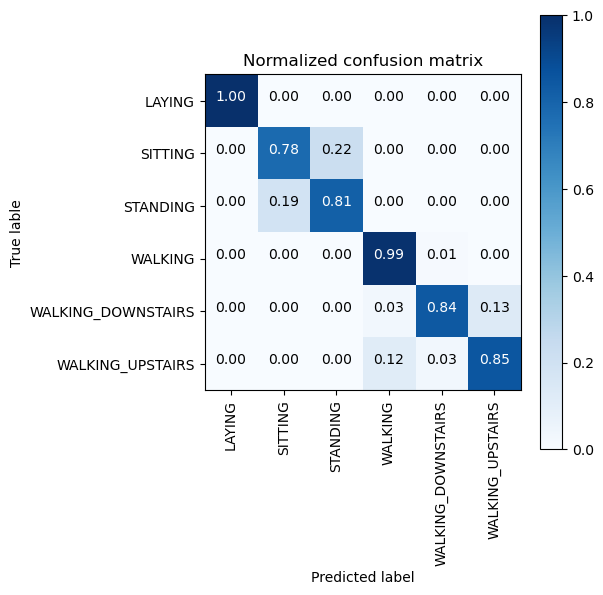

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.79      0.78      0.78       491
          STANDING       0.80      0.81      0.81       532
           WALKING       0.88      0.99      0.93       496
WALKING_DOWNSTAIRS       0.95      0.84      0.89       420
  WALKING_UPSTAIRS       0.88      0.85      0.87       471

          accuracy                           0.88      2947
         macro avg       0.88      0.88      0.88      2947
      weighted avg       0.88      0.88      0.88      2947



In [92]:
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
perform_model(dt_grid)

training the model..
Done....!

==> training time:- 0:25:10.945737

Predicting test data without hmm
Done....!

==> testing time without hmm:- 0:00:00.134004

==> Accuracy:- 0.9253478113335596


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 432  59   0   0   0]
 [  0  39 493   0   0   0]
 [  0   0   0 480  12   4]
 [  0   0   0  17 358  45]
 [  0   0   0  38   6 427]]
<class 'numpy.ndarray'>


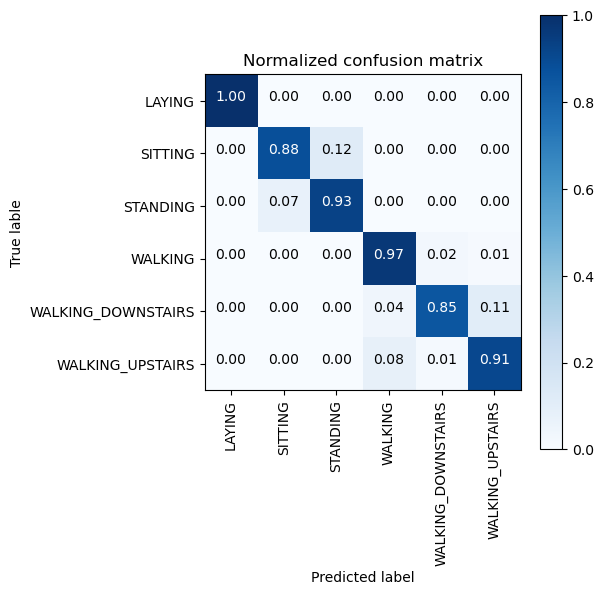

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.88      0.90       491
          STANDING       0.89      0.93      0.91       532
           WALKING       0.90      0.97      0.93       496
WALKING_DOWNSTAIRS       0.95      0.85      0.90       420
  WALKING_UPSTAIRS       0.90      0.91      0.90       471

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947

<class 'numpy.ndarray'>
==> Accuracy:- 0.9331523583305056


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  1 432  58   0   0   0]
 [  0  33 499   0   0   0]
 [  0   0   0 485   8   3]
 [  0   0   0  15 360  45]
 [  0   0   0  28   6 437]]
<class 'numpy.ndarray'>


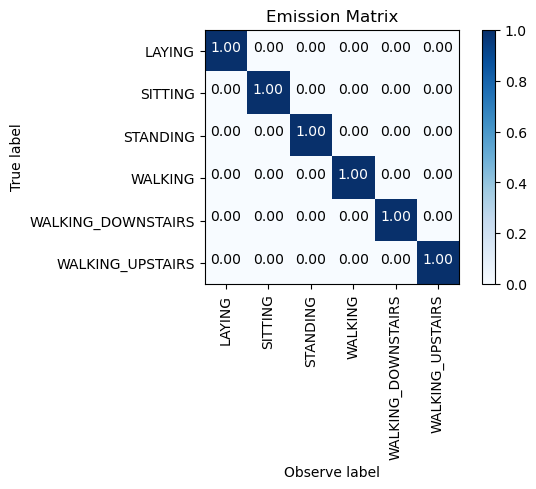

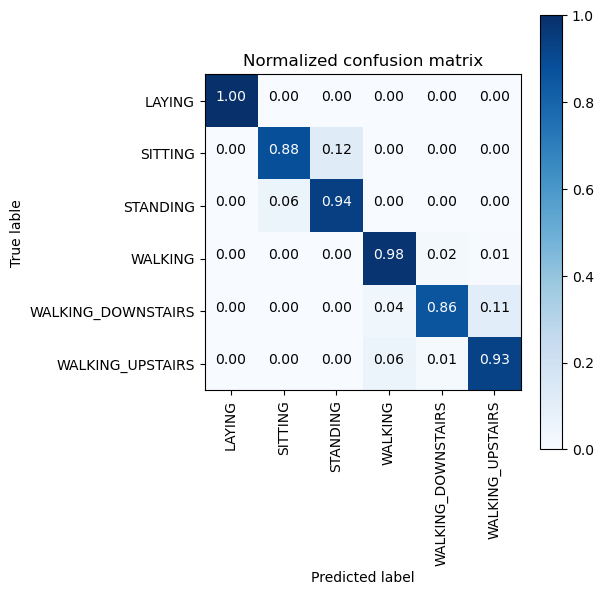

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.93      0.88      0.90       491
          STANDING       0.90      0.94      0.92       532
           WALKING       0.92      0.98      0.95       496
WALKING_DOWNSTAIRS       0.96      0.86      0.91       420
  WALKING_UPSTAIRS       0.90      0.93      0.91       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



In [93]:
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
perform_model(rfc_grid)